# 尝试运行模型

Jupyter notebook 是交互式的代码IDE，非常适合新手，建议最开始在这里探索我们的模型。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

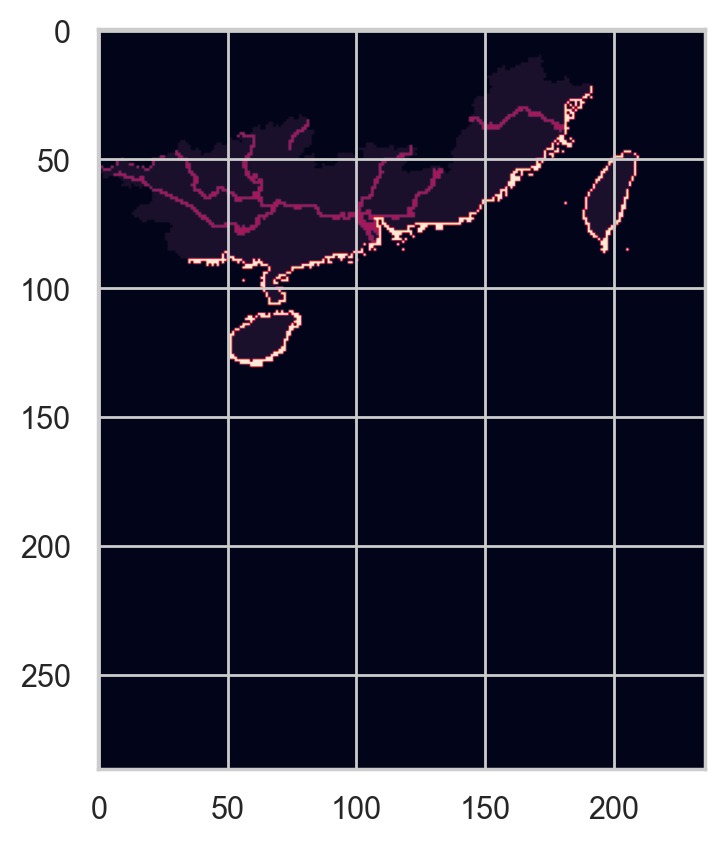

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="notebook", style="whitegrid")

import rasterio

with rasterio.open(cfg.db.lim_h) as dataset:
    arr = dataset.read(1)
    plt.imshow(arr)

注意下面这里需要把你上面读取的参数配置文件，作为参数`parameters=cfg`输入到模型中。

In [3]:
# 从这个路径加载模型
from abses_sce.model import Model

model = Model(parameters=cfg)
model.params.save_plots = False

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

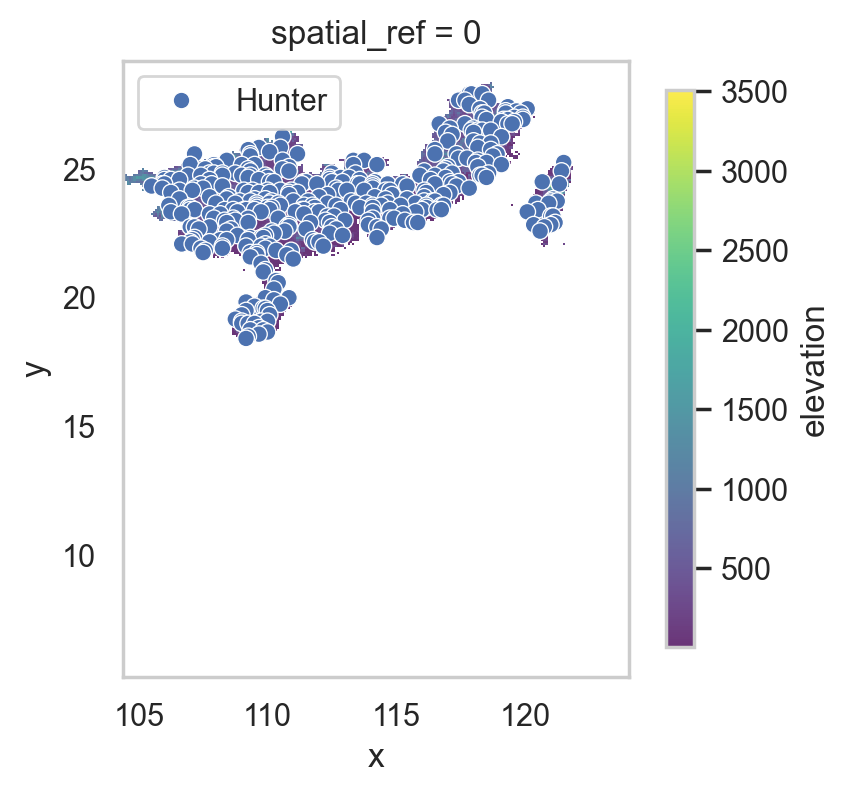

In [4]:
model.nature.plot.show("elevation")

<Axes: xlabel='size', ylabel='Count'>

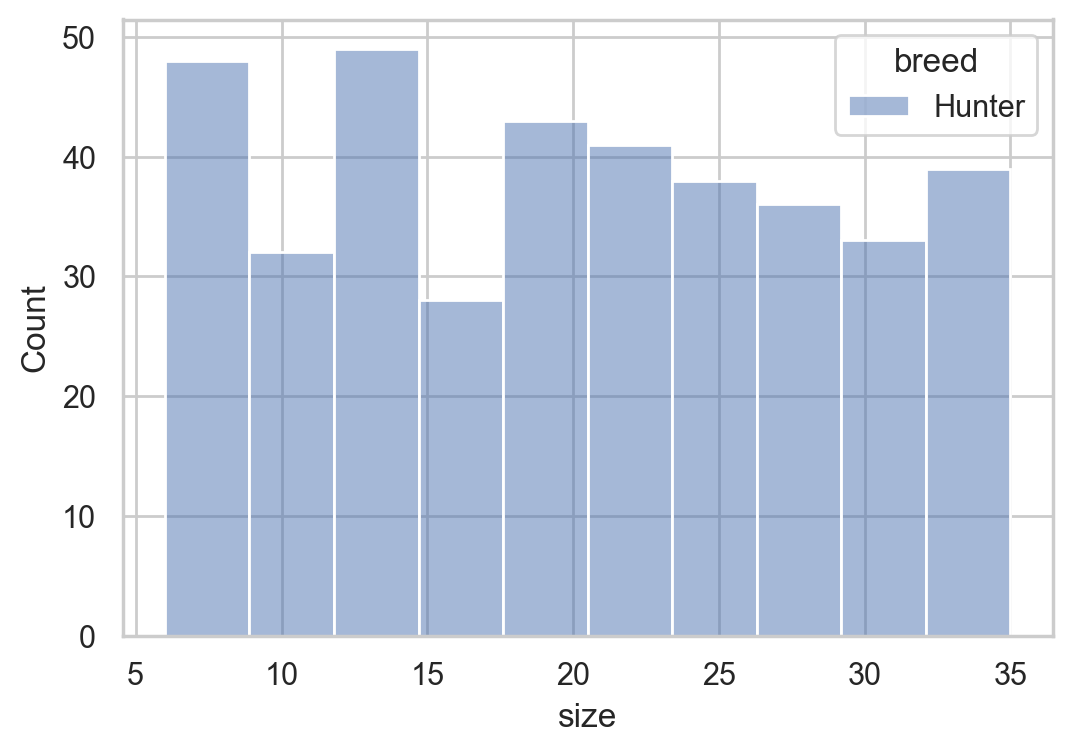

In [5]:
model.actors.plot.hist("size")

农民可以停留的可耕种土地有3074，分布如下图：


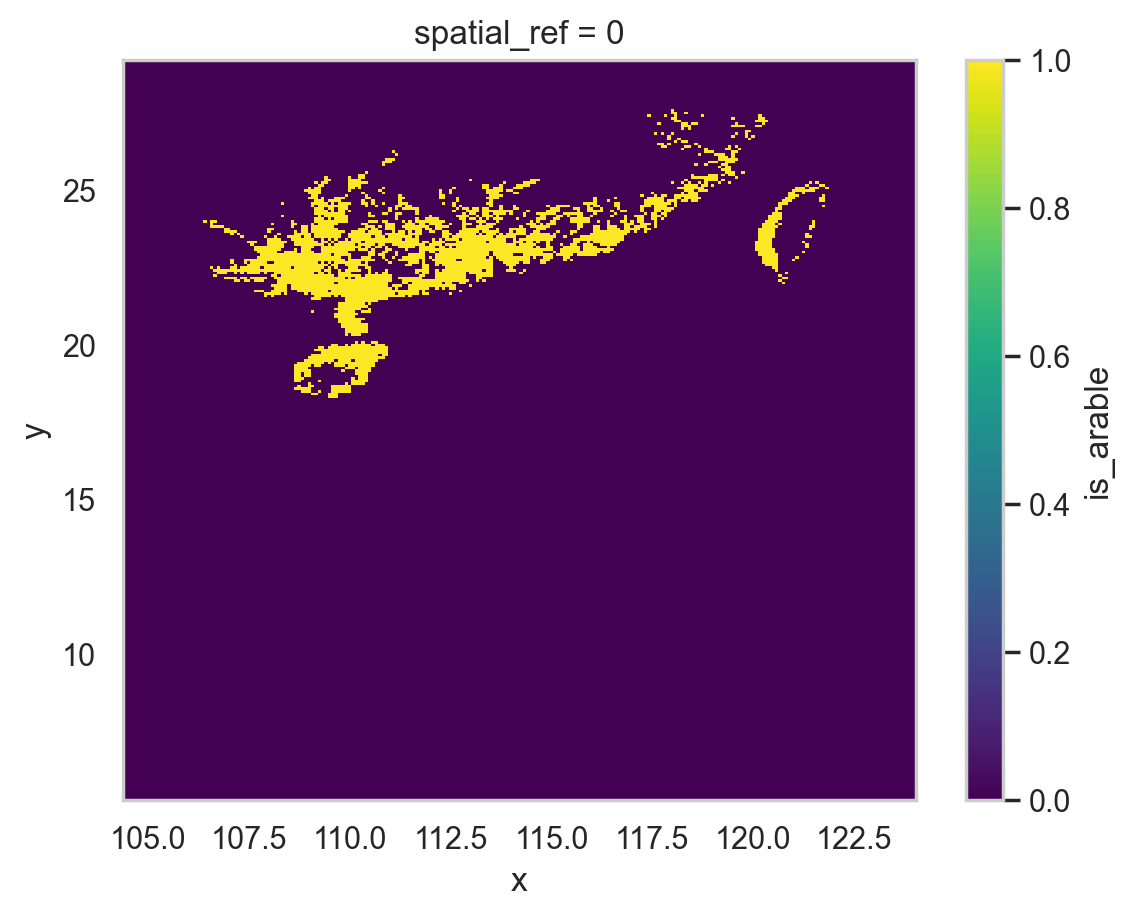

In [6]:
arable_land = model.nature.get_xarray("is_arable")
print(f"农民可以停留的可耕种土地有{arable_land.to_numpy().sum()}，分布如下图：")
arable_land.plot()

水稻农民可以停留的可耕种土地有924，分布如下图：


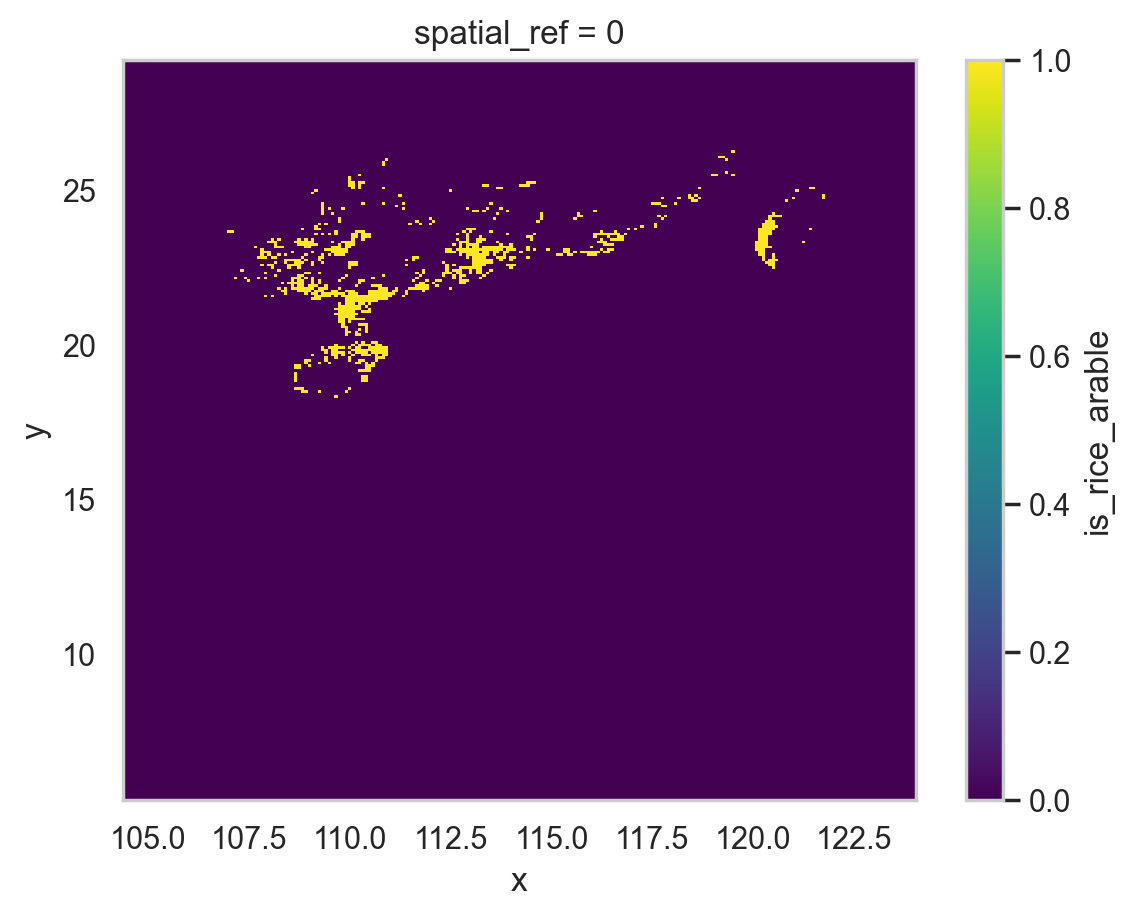

In [7]:
rice_arable = model.nature.patchmodule.get_xarray("is_rice_arable")
print(f"水稻农民可以停留的可耕种土地有{rice_arable.to_numpy().sum()}，分布如下图：")
rice_arable.plot()

增加了初始的 Hunters，随机生成在地图上

(<Axes: title={'center': 'spatial_ref = 0'}, xlabel='Farmers', ylabel='y'>,
 <Axes: title={'center': 'spatial_ref = 0'}, xlabel='Hunters', ylabel='y'>)

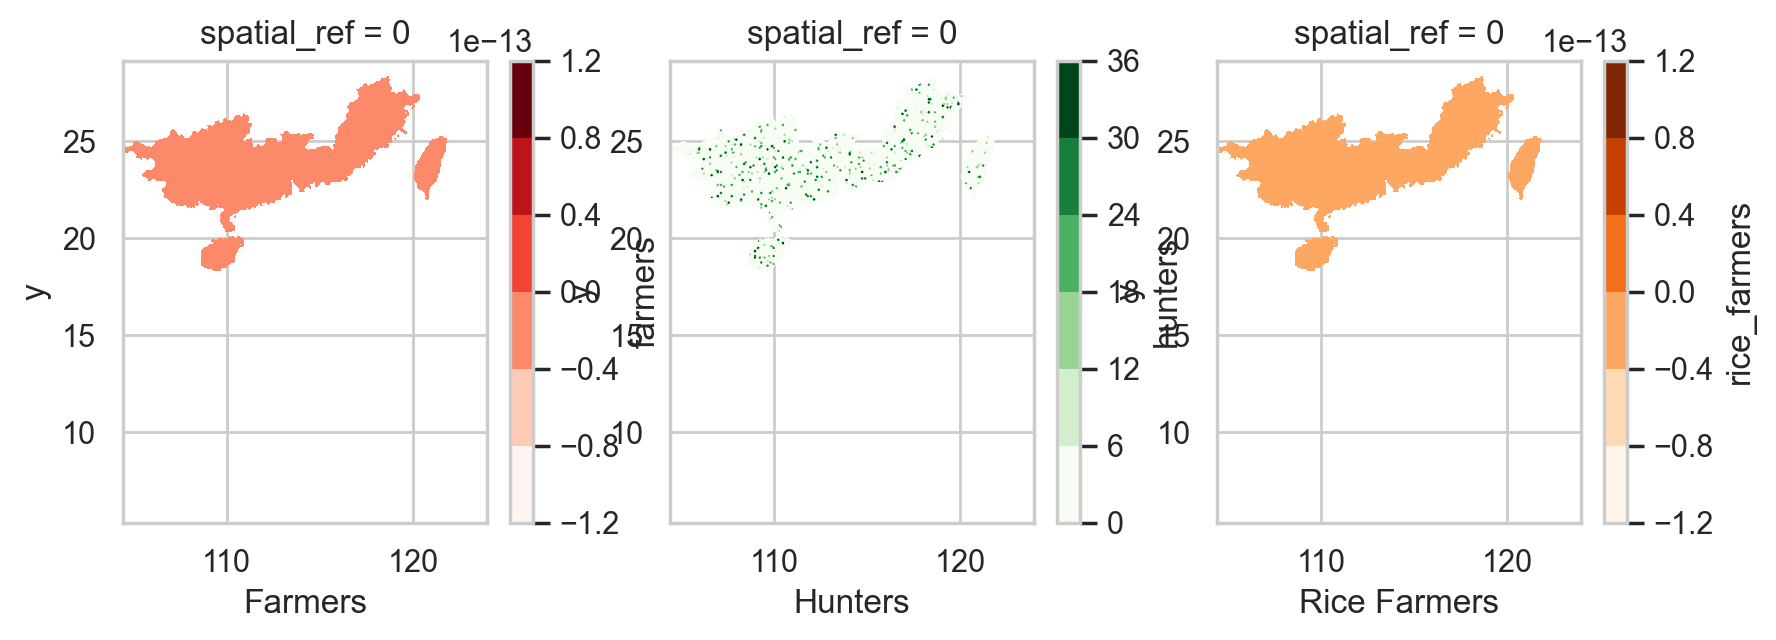

In [8]:
model.plot.heatmap()

设置100年的话，模型的运行可能需要几分钟的时间，以此类推，模型没运算完不要太着急。完成后会自动做出下面的折线图。

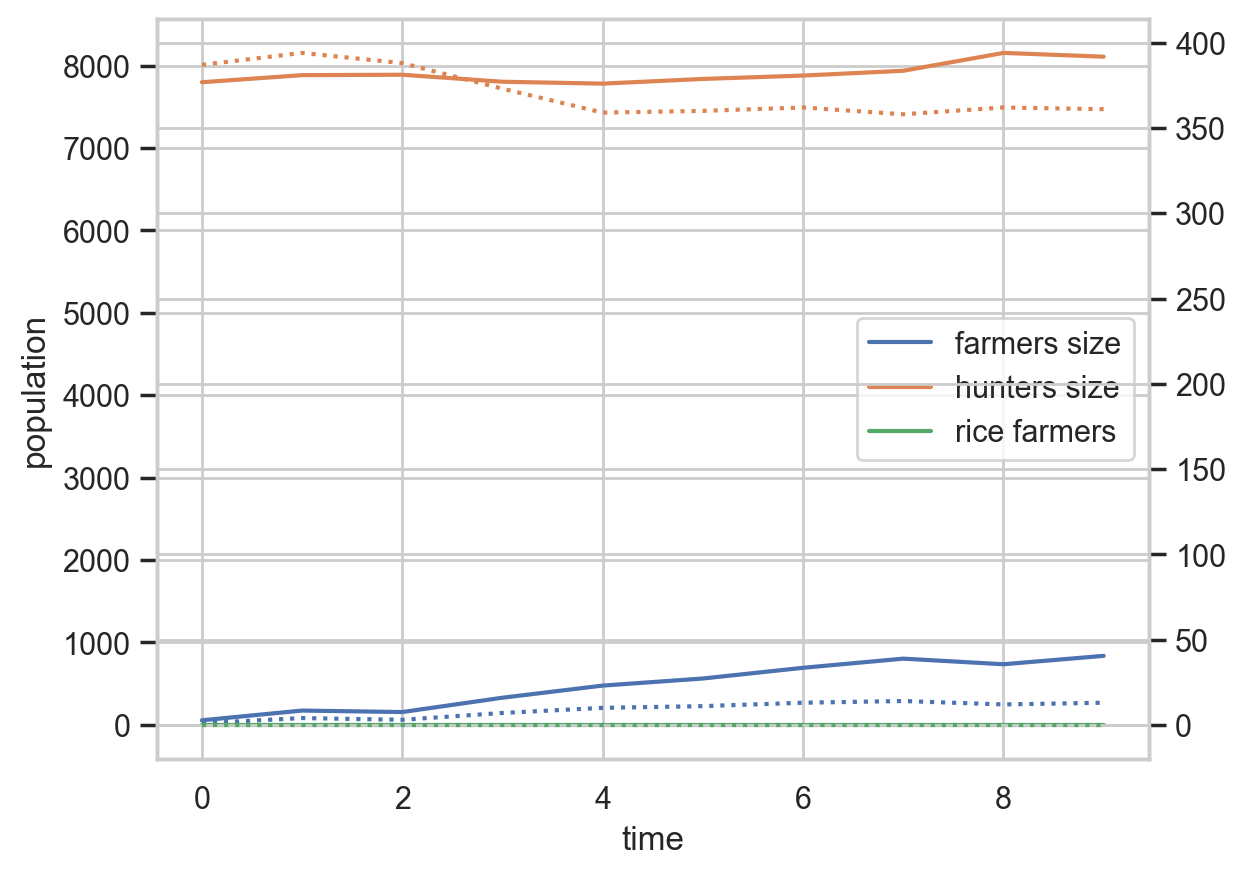

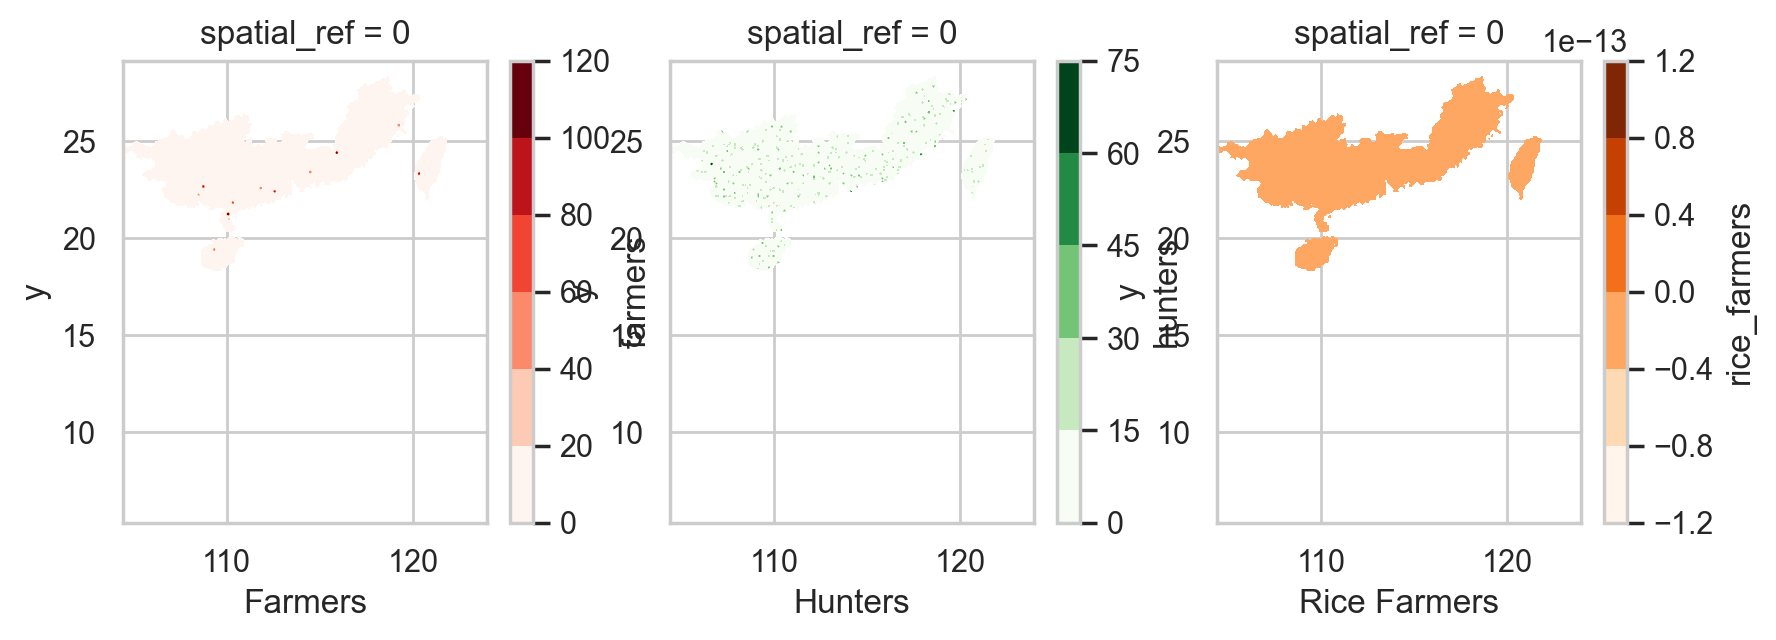

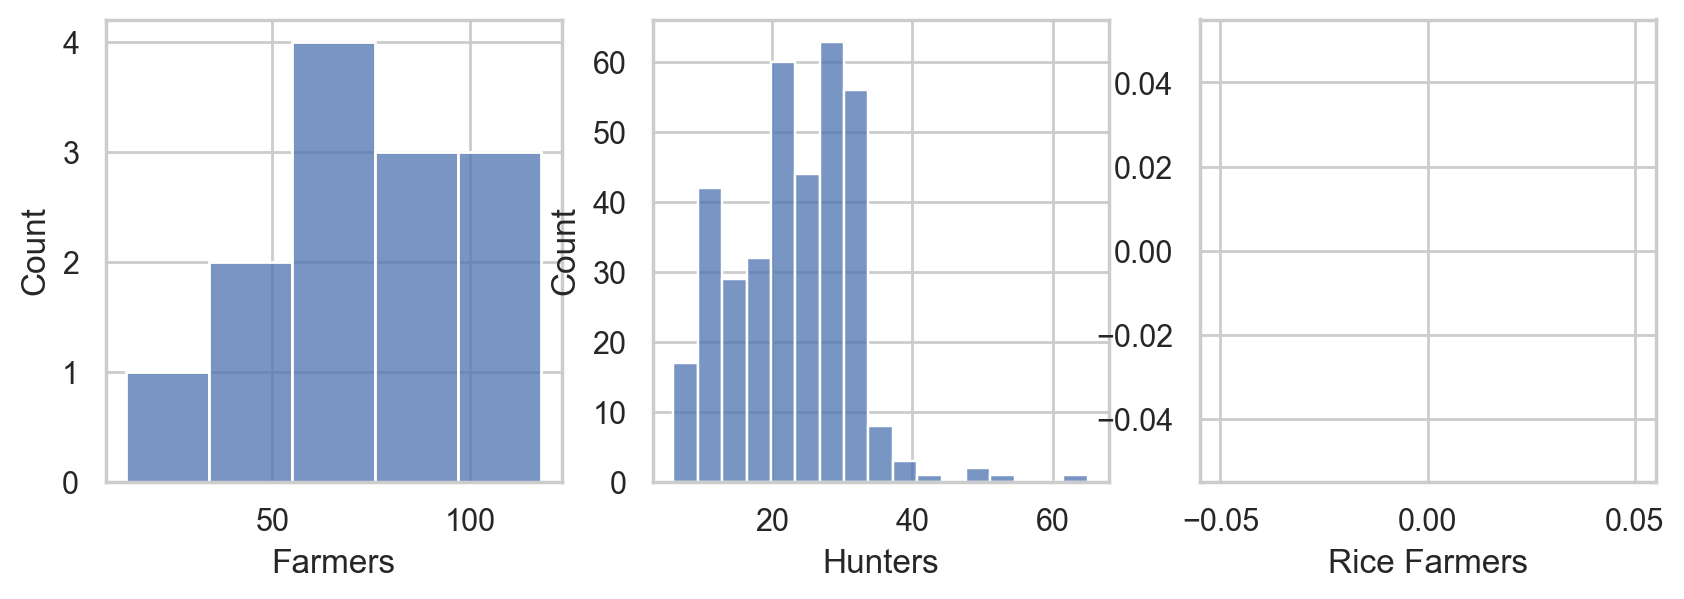

In [9]:
model.run_model()

展示主体的信息

In [10]:
agent = model.actors.random.choice()
agent.report()

unique_id          551
breed           Hunter
size              24.0
position     (100, 66)
dtype: object

(<Axes: title={'center': 'spatial_ref = 0'}, xlabel='Farmers', ylabel='y'>,
 <Axes: title={'center': 'spatial_ref = 0'}, xlabel='Hunters', ylabel='y'>)

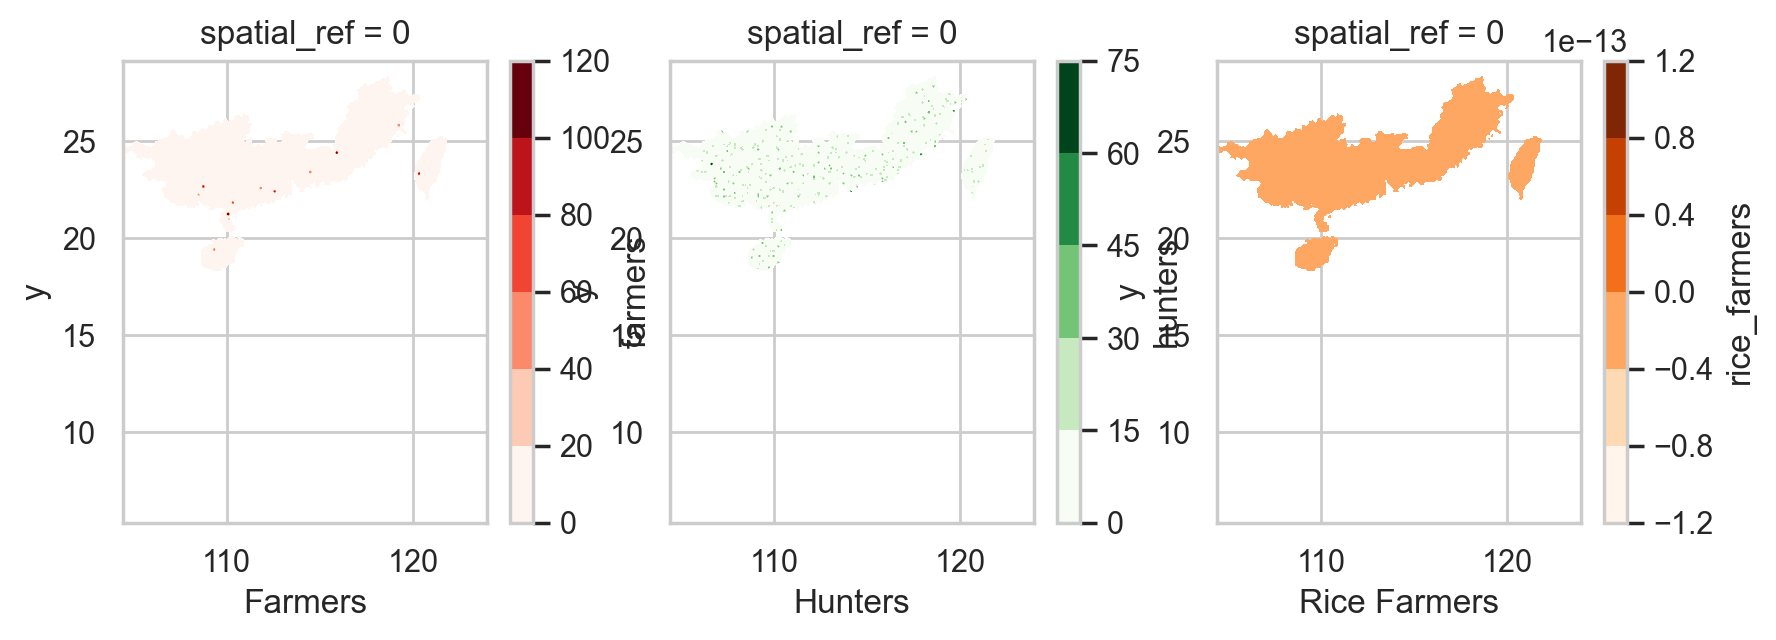

In [11]:
model.plot.heatmap()

In [12]:
for cell in model.nature.array_cells.ravel():
    if len(cell.agents) > 1:
        cell.agents

In [13]:
model.hunters
model.farmers

<ActorsList: (359)Hunter>

<ActorsList: (13)Farmer>

(<Axes: xlabel='Population'>, <Axes: xlabel='Groups'>)

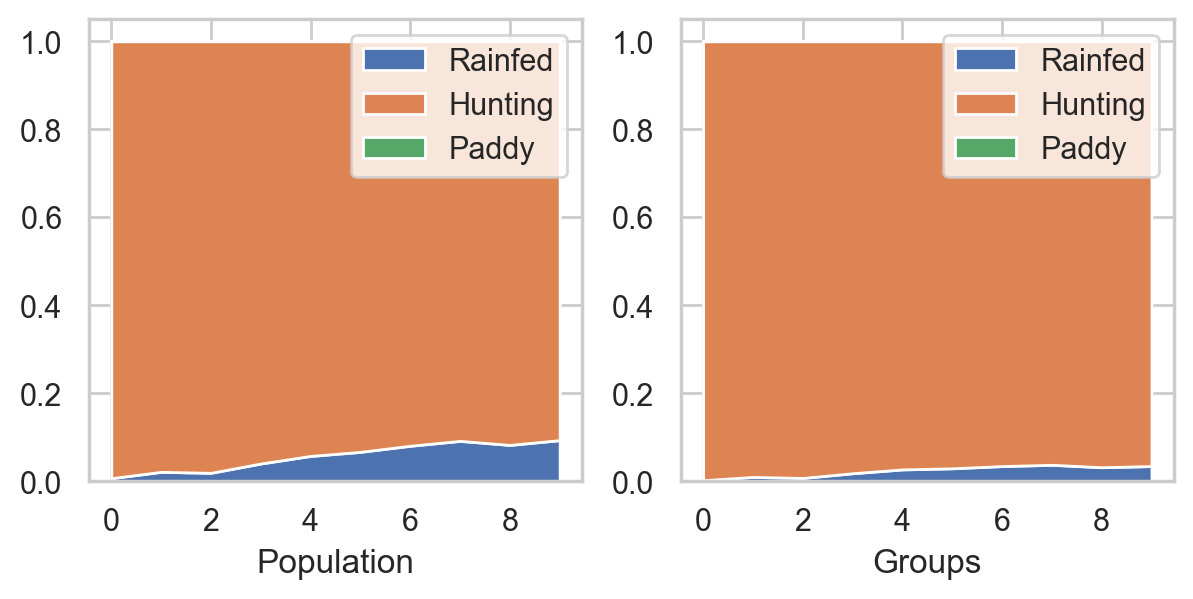

In [14]:
model.plot.stack_dynamic()